# Import Library

In [1]:
# Data analysis and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import pathlib
import matplotlib.image as mpimg
import random
from sklearn.utils import shuffle
%matplotlib inline 

# Preprocess, model, evaluation
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils
from tensorflow.keras.utils import load_img
from sklearn.metrics import confusion_matrix, classification_report

# Load Data

In [2]:
# Before running this cell make sure "Rice_image_DataSet" zip file is downloaded from:
# https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("Rice_Image_Dataset.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Walk through Rice_Image_dataset directory and list number of files
for dirpath, dirnames, filenames in os.walk("Rice_Image_Dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 5 directories and 1 files in 'Rice_Image_Dataset'.
There are 0 directories and 15000 files in 'Rice_Image_Dataset/Arborio'.
There are 0 directories and 15000 files in 'Rice_Image_Dataset/Basmati'.
There are 0 directories and 15000 files in 'Rice_Image_Dataset/Ipsala'.
There are 0 directories and 15000 files in 'Rice_Image_Dataset/Jasmine'.
There are 0 directories and 15000 files in 'Rice_Image_Dataset/Karacadag'.


# Exploratory Data Analysis

In [2]:
# Get class names for the multi-class dataset
# Turning the directory path into a Python path
dir = "/content/Rice_Image_Dataset"
data_dir = pathlib.Path(dir)

# Delete files in Rice_Image_Dataset directory which are not needed for preprocessing 
!rm /content/Rice_Image_Dataset/Rice_Citation_Request.txt

# Create a list of class_names from subdirectories
class_names = sorted([item.name for item in data_dir.glob('*')])
print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [3]:
# Combine all data and shuffle
img_path = []
img_label = []
for label in class_names:
    for path in os.listdir(dir+'/'+label):
        img_path.append(dir+'/'+label+'/'+path)
        img_label.append(label)
img_path, img_label = shuffle(img_path, img_label)

In [4]:
# Split data to train and test sets
X_train_path, X_test_path, y_train, y_test = train_test_split(img_path, img_label, test_size=0.1, random_state=42)

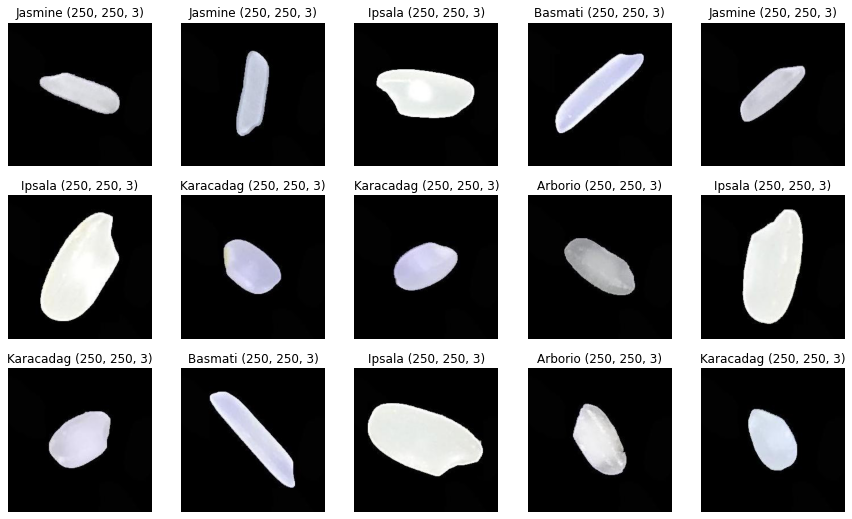

In [5]:
# Visualize random images (and shape of each image) from training set
plt.figure(figsize=(15,9))
for i in range(15):
  rand_num = np.random.randint(len(X_train_path))
  plt.subplot(3, 5, i+1)
  img = mpimg.imread(X_train_path[i])
  plt.imshow(img)
  plt.title(f'{y_train[i]} {img.shape}')
  plt.axis("off");

# Preprocess the data

In [6]:
# load and convert images to numpy arrays
# Reduce pixel size to use less memory 
img_size =112
X_train = [np.uint8(load_img(path, target_size=(img_size,img_size))) for path in X_train_path]
X_test = [np.uint8(load_img(path, target_size=(img_size,img_size))) for path in X_test_path]
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

((67500, 112, 112, 3), (7500, 112, 112, 3))

In [7]:
# Encode the labels
y_train = [class_names.index(class_name) for class_name in y_train]
y_test = [class_names.index(class_name) for class_name in y_test]

y_train = utils.to_categorical(tf.expand_dims(y_train, axis=1), num_classes=len(class_names))
y_test = utils.to_categorical(tf.expand_dims(y_test, axis=1), num_classes=len(class_names))

y_train.shape, y_test.shape

((67500, 5), (7500, 5))

## Data Augmentation

In [8]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Model, Predict and Evaluate

## Train a CNN model

In [9]:
# Create CNN model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(20, 5, activation='relu', input_shape=(img_size, img_size, 3)),
  tf.keras.layers.Conv2D(20, 5, activation='relu'),
  tf.keras.layers.MaxPool2D(padding='same'),
  tf.keras.layers.Conv2D(20, 5, activation='relu'),
  tf.keras.layers.Conv2D(20, 5, activation='relu'),
  tf.keras.layers.MaxPool2D(padding='same'),
  tf.keras.layers.Conv2D(20, 5, activation='relu'),
  tf.keras.layers.Conv2D(20, 5, activation='relu'),
  tf.keras.layers.MaxPool2D(padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32, subset='training'),
                    epochs = 5,
                    validation_data = train_datagen.flow(X_train, y_train, batch_size=32, subset='validation'))

Epoch 1/5
1899/1899 [==============================] - 37s 14ms/step - loss: 0.1680 - accuracy: 0.9411 - val_loss: 0.1325 - val_accuracy: 0.9550
Epoch 2/5
1899/1899 [==============================] - 27s 14ms/step - loss: 0.1000 - accuracy: 0.9673 - val_loss: 0.0985 - val_accuracy: 0.9630
Epoch 3/5
1899/1899 [==============================] - 27s 14ms/step - loss: 0.0606 - accuracy: 0.9807 - val_loss: 0.0453 - val_accuracy: 0.9843
Epoch 4/5
1899/1899 [==============================] - 27s 14ms/step - loss: 0.0410 - accuracy: 0.9870 - val_loss: 0.0282 - val_accuracy: 0.9907
Epoch 5/5
1899/1899 [==============================] - 27s 14ms/step - loss: 0.0311 - accuracy: 0.9903 - val_loss: 0.0551 - val_accuracy: 0.9806


In [10]:
# Visualize layers in our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 108, 20)      1520      
                                                                 
 conv2d_1 (Conv2D)           (None, 104, 104, 20)      10020     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 52, 52, 20)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 20)        10020     
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 20)        10020     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 20)       0         
 2D)                                                    

## Predict and Evaluate Test Dataset

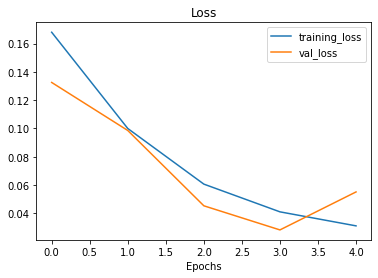

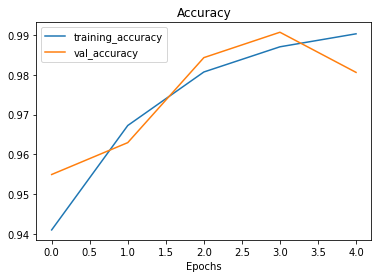

In [11]:
# Plot accuracy and loss curves for training and validation sets
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(history.history['loss']))

# Plot loss
plt.figure()
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [12]:
# Evaluate the model on the test data
print("Evaluation on Test data \n")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f"\nModel loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

Evaluation on Test data 

235/235 [==============================] - 2s 6ms/step - loss: 6.7701 - accuracy: 0.9796

Model loss on test set: 6.7701416015625
Model accuracy on test set: 97.96%


In [13]:
# Model prediction for test data
pred = model.predict(X_test)

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Match the truth ground label to class_names
y_true = [y_test[i].argmax() for i in range(len(y_test))]
y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

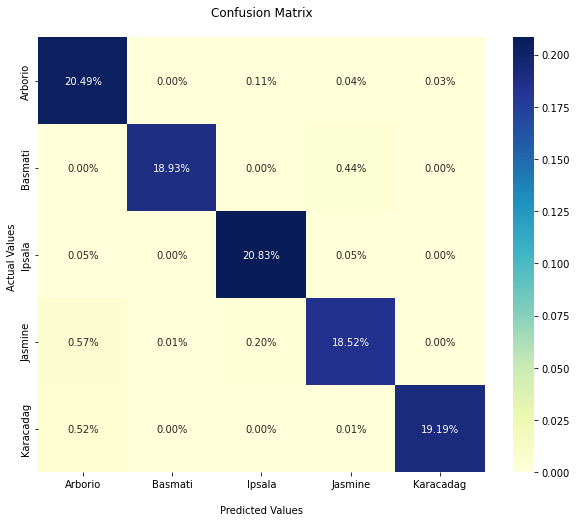

In [14]:
# Plot confusion matrix from predictions
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlGnBu')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

In [15]:
# Classification report
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     Arborio      0.947     0.992     0.969      1550
     Basmati      0.999     0.977     0.988      1453
      Ipsala      0.985     0.995     0.990      1570
     Jasmine      0.971     0.959     0.965      1448
   Karacadag      0.999     0.973     0.986      1479

    accuracy                          0.980      7500
   macro avg      0.980     0.979     0.980      7500
weighted avg      0.980     0.980     0.980      7500



# Summary

There is no sign of overfitting or underfitting since accuracies for training, validation, and test sets are all around 98%.